In [3]:
import os
os.chdir('../../')

In [4]:
from utils.musicautobot.numpy_encode import *
from utils.musicautobot.utils.file_processing import process_all, process_file
from utils.musicautobot.config import *
from utils.musicautobot.music_transformer import *
from utils.musicautobot.utils.setup_musescore import setup_musescore
setup_musescore()

2023-04-24 22:51:56.408890: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# Colab cannot play music directly from music21 - must convert to .wav first
def play_wav(stream):
    out_midi = stream.write('midi')
    out_wav = str(Path(out_midi).with_suffix('.wav'))
    FluidSynth("font.sf2").midi_to_audio(out_midi, out_wav)
    return Audio(out_wav)

# Training 

### Load Paths

In [8]:
# Location of your midi files
midi_path =  Path('/Users/caslabs/Documents/port/music-generation/data/musicautobot-midi/examples')

# Location of saved datset
data_path = Path('/Users/caslabs/Documents/port/music-generation/data/numpy')

In [9]:
# Data
#data = MusicDataBunch.empty(data_path)
#vocab = data.vocab

# For Saved Data:
data_save_name = 'musicitem_data_save.pkl'

In [10]:
midi_files = get_files(midi_path, '.mid', recurse=True)
data = MusicDataBunch.from_files(midi_files, data_path, processors=[Midi2ItemProcessor()], bs=4, bptt=128, encode_position=False)

/Users/caslabs/Documents/port/music-generation/utils/musicautobot/numpy_encode.py:53: StreamIteratorInefficientWarning: highestTime is not defined on StreamIterators. Call .stream() first for efficiency
  highest_time = max(s.flat.getElementsByClass('Note').highestTime, s.flat.getElementsByClass('Chord').highestTime)
/Users/caslabs/opt/anaconda3/envs/musicautobot/lib/python3.10/site-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


In [11]:
midi_files

[PosixPath('/Users/caslabs/Documents/port/music-generation/data/musicautobot-midi/examples/Levels - Avicii - Verse.mid'),
 PosixPath('/Users/caslabs/Documents/port/music-generation/data/musicautobot-midi/examples/Scary Monsters And Nice Sprites - Skrillex - Pre-Chorus.mid'),
 PosixPath('/Users/caslabs/Documents/port/music-generation/data/musicautobot-midi/examples/Can You Feel The Love Tonight - Elton John - Verse.mid'),
 PosixPath('/Users/caslabs/Documents/port/music-generation/data/musicautobot-midi/examples/Locked Out Of Heaven - Bruno Mars - Chorus.mid'),
 PosixPath('/Users/caslabs/Documents/port/music-generation/data/musicautobot-midi/examples/In The Hall Of The Mountain King - Edvard Grieg - Intro.mid'),
 PosixPath('/Users/caslabs/Documents/port/music-generation/data/musicautobot-midi/examples/Colors Of The Wind - Disney - Chorus.mid'),
 PosixPath('/Users/caslabs/Documents/port/music-generation/data/musicautobot-midi/examples/I Want You Back - Jackson 5 - Intro.mid'),
 PosixPath(

In [12]:
learn = music_model_learner(data, arch=TransformerXL, config=default_config())

## Prediction

#### Choose existing midi file as a starting point

In [13]:
midi_files = get_files(midi_path, recurse=True, extensions='.mid'); midi_files[:4]

[PosixPath('/Users/caslabs/Documents/port/music-generation/data/musicautobot-midi/examples/Levels - Avicii - Verse.mid'),
 PosixPath('/Users/caslabs/Documents/port/music-generation/data/musicautobot-midi/examples/Scary Monsters And Nice Sprites - Skrillex - Pre-Chorus.mid'),
 PosixPath('/Users/caslabs/Documents/port/music-generation/data/musicautobot-midi/examples/Can You Feel The Love Tonight - Elton John - Verse.mid'),
 PosixPath('/Users/caslabs/Documents/port/music-generation/data/musicautobot-midi/examples/Locked Out Of Heaven - Bruno Mars - Chorus.mid')]

In [14]:
idx = 1
f = midi_files[idx]; f

PosixPath('/Users/caslabs/Documents/port/music-generation/data/musicautobot-midi/examples/Scary Monsters And Nice Sprites - Skrillex - Pre-Chorus.mid')

In [15]:
import warnings
warnings.simplefilter("ignore", UserWarning)

In [31]:
from fastai.callbacks import *

class SaveModelAtEpochs(Callback):
    def __init__(self, epochs_to_save):
        self.epochs_to_save = epochs_to_save

    def after_epoch(self):
        if self.epoch + 1 in self.epochs_to_save:
            save_path = f"model_epoch_{self.epoch+1}"
            self.learn.save(save_path)
            print(f"Model saved at {save_path}")

In [32]:
# Instantiate the custom callback and specify the epochs you want to save the model at
save_model_callback = SaveModelAtEpochs(epochs_to_save=[2, 4])

In [35]:
# Pass the custom callback to the fit_one_cycle function
learn.fit_one_cycle(4, callbacks=[save_model_callback])



KeyboardInterrupt: 

In [33]:
import matplotlib.pyplot as plt

In [34]:
history = learn.recorder

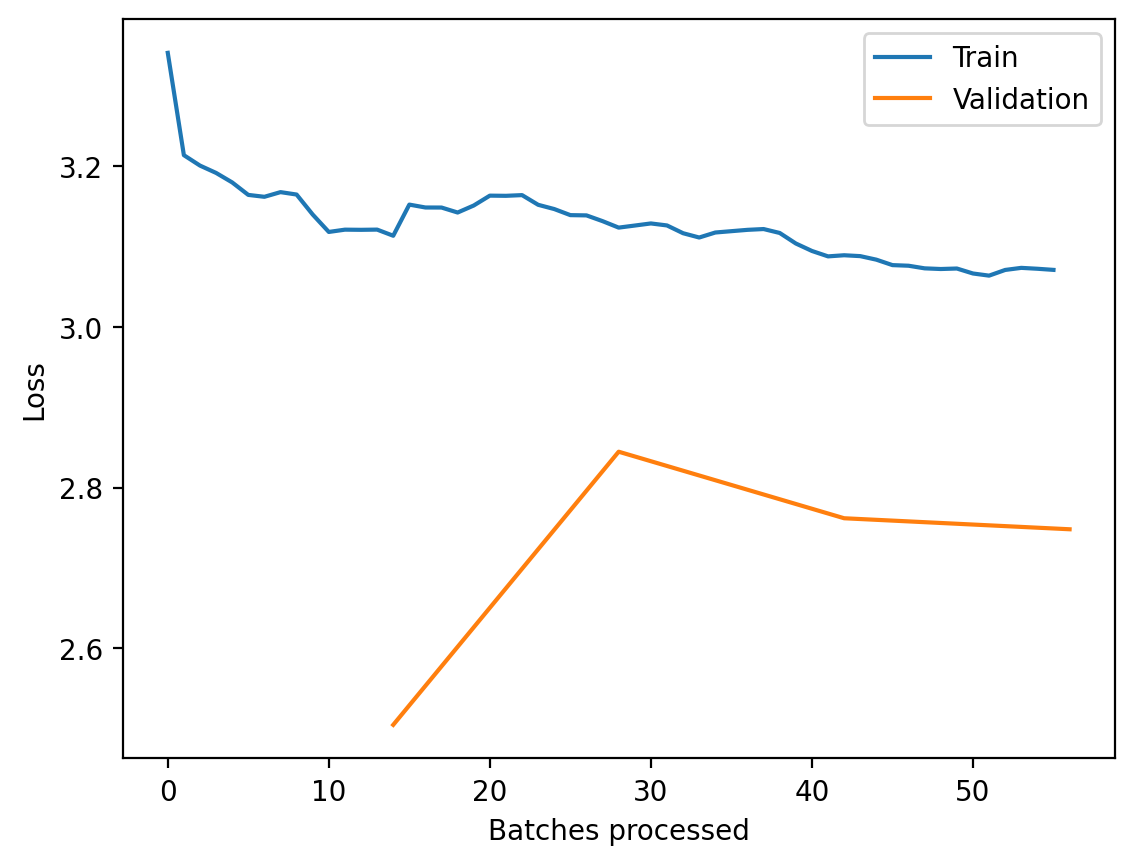

In [28]:
history.plot_losses()

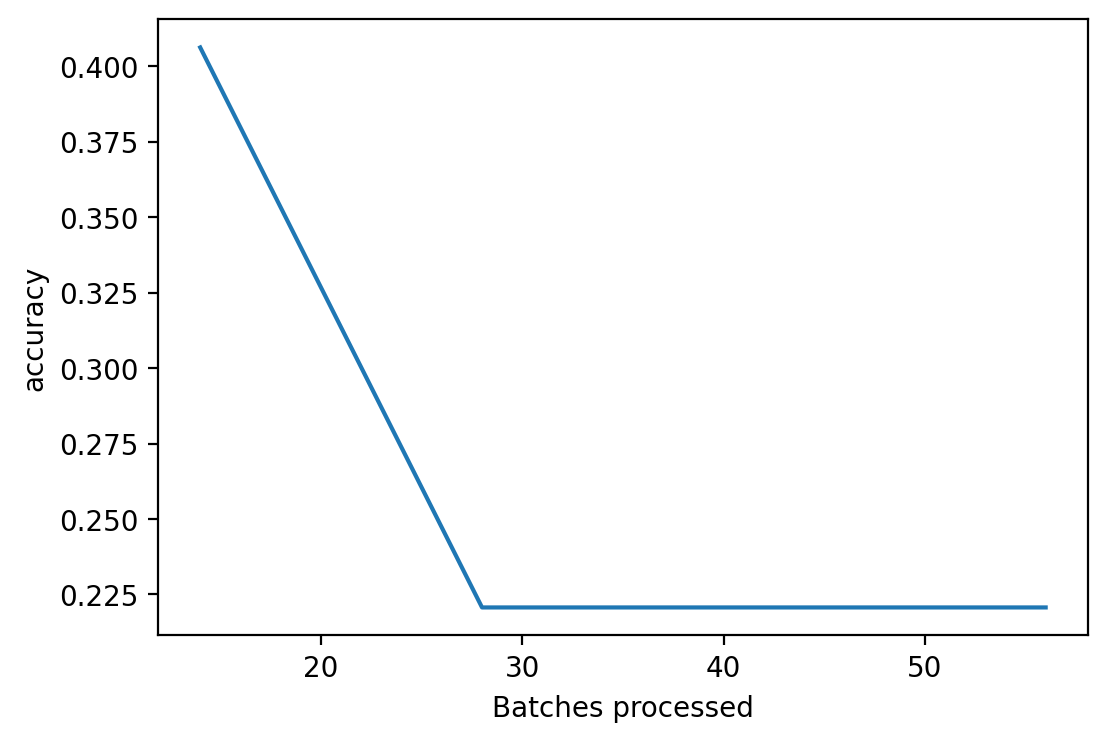

In [29]:
# Accuracy
history.plot_metrics()

In [30]:
# Save model
learn.save('music_transformer')

PosixPath('/Users/caslabs/Documents/port/music-generation/data/numpy/models/music_transformer.pth')